# Variant effect prediction

In [1]:
import warnings
warnings.filterwarnings('ignore')
from datasets import load_dataset
from functools import reduce
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
from math import sqrt
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, fisher_exact

import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay
from tqdm import tqdm
tqdm.pandas()

In [2]:
COORDINATES = ["chrom", "pos", "ref", "alt"]

def load_models(V, dataset_path, dataset_name):
    d = Path(f"../../results/preds/{dataset_path}")
    models = dataset_models[dataset_name]
    if not isinstance(models, list):
        models = gather_unique_values(dataset_models[dataset_name])
    for m in tqdm(models):
        model_name = model_renaming.get(m, m)
        model_path = d / f"{m}.parquet"
        V = V.with_columns(pl.read_parquet(model_path, columns="score")["score"].alias(model_name))
    return V

def get_odds_ratio(df, threshold_ns):
    rows = []
    negative_set = df.filter(~pl.col("label")).sort("score")
    for n in threshold_ns:
        threshold = negative_set[n]["score"]
        group_counts = (
            df.group_by(["label", pl.col("score") <= threshold]).len()
            .sort(["label", "score"])["len"].to_numpy().reshape((2,2))
        )
        odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
        rows.append([n, odds_ratio, p_value])
    return pl.DataFrame(rows, schema=["n", "Odds ratio", "p_value"])

def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

def plot_curve(V, results, curve, title, save_path=None):
    n_pos, n_neg = results.n_pos.iloc[0], results.n_neg.iloc[0]
    sample_size = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
    title = f"{title}\n{sample_size}"
    if curve == "ROC":
        plot_f = RocCurveDisplay
        metric = "AUROC"
        xlabel = 'False Positive Rate'
        ylabel = 'True Positive Rate'
        random_plot = lambda ax: ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
    elif curve == "PR":
        pos_prop = n_pos / (n_pos + n_neg)
        plot_f = PrecisionRecallDisplay
        metric = "AUPRC"
        xlabel = 'Recall'
        ylabel = 'Precision'
        random_plot = lambda ax: ax.axhline(y=pos_prop, linestyle="--", color="gray")
    
    # note: latest sklearn has argument: plot_chance_level
    fig, ax = plt.subplots(figsize=(3,3))

    for m in results.Model.unique()[::-1]:
        AUC = results[results.Model==m].iloc[0][metric]
        plot_f.from_predictions(V.label, -V[m], name=m, ax=ax, label=f"{m} (AUC={AUC:.3f})", color=palette[m])
        
    random_plot(ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    sns.despine()
    
    ax.legend();
    # get handles and labels
    handles, labels = ax.get_legend_handles_labels()
    # reverse the order
    handles, labels = handles[::-1], labels[::-1]
    # create the legend with the reversed order
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(title);
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")
        

color_neg = sns.color_palette("Dark2")[0]
color_pos = sns.color_palette("Dark2")[1]
palette_label = {
    "gnomAD/\nCommon": color_neg,
    "ClinVar/\nPathogenic": color_pos,
    "COSMIC/\nFrequent": color_pos,
    "OMIM/\nPathogenic": color_pos,
    "gnomAD/\nRare": color_pos,
    
    "Common": color_neg,
    "Rare": color_pos,
}

def barplot(
    df, metric, title, groupby="Consequence",
    width=2, height=2, nrows=1, ncols=1,
    save_path=None, wspace=None, hspace=None,
    x=None, y=None,
):
    if groupby not in df.columns: df[groupby] = "all"
    groups = df[groupby].unique()
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, sharex=False, sharey=False,
        figsize=(width*ncols, height*nrows), squeeze=False,
        gridspec_kw={'wspace': wspace, 'hspace': hspace},
    )

    for group, ax in zip(groups, axes.flat):
        df_g = df[df[groupby]==group].sort_values(metric, ascending=False)
        n_pos, n_neg = df_g.n_pos.iloc[0], df_g.n_neg.iloc[0]

        if metric == "AUROC":
            baseline = 0.5
        elif metric == "AUPRC":
            baseline = n_pos / (n_pos + n_neg)
        elif metric == "Odds ratio":
            baseline = 1

        g = sns.barplot(
            data=df_g,
            y="Model",
            x=metric,
            palette=palette,
            ax=ax,
        )
        sns.despine()
        sample_size = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
        subtitle = f"{group}\n{sample_size}" if len(groups) > 1 else sample_size
        g.set_title(subtitle, fontsize=10)
        g.set(xlim=baseline, ylabel="")

        for bar, model in zip(g.patches, df_g.Model):
            if metric == "Odds ratio":
                text = f'{bar.get_width():.1f}'
                if df_g[df_g.Model==model].p_value.iloc[0] >= 0.05:
                    text = text + " (NS)"
            else:
                text = f'{bar.get_width():.3f}'
            
            g.text(
                max(bar.get_width(), baseline),  # X position, here at the end of the bar
                bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
                text,  # Text to be displayed, formatted to 3 decimal places
                va='center'  # Vertical alignment
            )
        
        #if metric == "Odds ratio":
        #    for index, row in df_g.iterrows():
        #        if row['p_value'] >= 0.05:
        #            g.text(y=index, x=row['Odds ratio'], s='(ns)', ha='right')
        
    plt.suptitle(title, x=x, y=y, fontsize=11)
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

def histplot_label(V, label_pos, label_neg, save_path=None, **kwargs):
    V["label"] = V.label.replace({True: label_pos, False: label_neg})
    plt.figure(figsize=(3,3))
    g = sns.histplot(
        data=V,
        x="GPN-MSA",
        hue="label",
        hue_order=[label_pos, label_neg],
        bins=25,
        stat="density",
        common_norm=False,
        common_bins=True,
        palette=palette_label,
        **kwargs,
    )
    sns.despine()
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")
        
        
def ecdfplot_label(V, save_path=None, **kwargs):
    plt.figure(figsize=(3,3))
    sns.ecdfplot(
        data=V,
        x="GPN-MSA",
        hue="label",
        palette=palette_label,
        **kwargs,
    )
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

In [3]:
plot_dir = "../../results/plots/"

In [4]:
palette = {
    "GPN-MSA": "C0",
    "CADD": "C1",
    "phyloP": "C2",
    "ESM-1b": "C3",
    "NT": "C4",
    "SpliceAI": "C5",
    "Enformer": "C6",
    "HyenaDNA": "C9",
    
    "phyloP-100v": "C2",
    "phyloP-241m": "C7",
    "phastCons-100v": "C8",

    "NT-500m-human-ref": "gray",
    "NT-500m-1000g": "gray",
    "NT-2.5b-1000g": "gray",
    "NT-2.5b-multi-species": "C4",
    
    r"Enformer ($L^1$)": "C6",
    r"Enformer ($L^2$)": "C7",
    r"Enformer ($L^\infty$)": "C8",
    
    "PrimateAI-3D": "black",
}

In [95]:
core_models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "CADD.RawScore",
    "phyloP",
    "phyloP-Zoonomia",
    "phastCons",
]

nt_model = "InstaDeepAI/nucleotide-transformer-2.5b-multi-species"
hyenadna_model = 'LongSafari/hyenadna-large-1m-seqlen-hf'

ablation_models = pd.read_csv("../../ablation_models.txt", header=None).values.ravel().tolist()[1:]
ablation_models = []

original_name = "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True"

model_renaming = { 
    # GPN-MSA
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",

    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    
    # HyenaDNA models
    'LongSafari/hyenadna-large-1m-seqlen-hf': "HyenaDNA",
    
    # Other models
    "CADD.RawScore": "CADD",
    "phyloP": "phyloP-100v",
    "phastCons": "phastCons-100v",
    "phyloP-Zoonomia": "phyloP-241m",
}

def gather_unique_values(d):
    unique_values = []
    seen = set()

    def gather_values(nested_dict):
        for value in nested_dict.values():
            if isinstance(value, dict):
                gather_values(value)
            elif isinstance(value, list):
                for item in value:
                    if item not in seen:
                        unique_values.append(item)
                        seen.add(item)

    gather_values(d)

    return unique_values

def apply_to_values(d, f):
    for key, value in d.items():
        if isinstance(value, dict):
            apply_to_values(value, f)
        elif isinstance(value, list):
            d[key] = [f(x) for x in value]
        else:
            d[key] = f(value)

consequence_bundles = {
    "splice_region": [
        "splice_polypyrimidine_tract",
        "splice_region",
        "splice_donor_region",
        "splice_donor",
        "splice_donor_5th_base",
        "splice_acceptor",
    ],
    "start_or_stop": {
        "stop_gained",
        "stop_lost",
        "start_lost",
    }
}
            
dataset_models = {
    "ClinVar": core_models + ["ESM-1b", nt_model, hyenadna_model] + ablation_models, #+ ["PrimateAI-3D"],

    "COSMIC": core_models + ["ESM-1b"] + ablation_models,  #+ ["PrimateAI-3D"],

    "OMIM": {
        "all": core_models + ablation_models,
        "Promoter": core_models + [nt_model],
        "Enhancer": core_models,
        "5' UTR": core_models + [nt_model],
        "3' UTR": core_models + [nt_model],
        "ncRNA": core_models + [nt_model],
    },
    
    "gnomAD": {
        "all": core_models,
        
        "missense": core_models + ["ESM-1b"], # + nt_models[-1:], # + ["PrimateAI-3D"],
        
        "synonymous": core_models,
        "5_prime_UTR": core_models,
        "3_prime_UTR": core_models,
        "upstream_gene": core_models,
        "downstream_gene": core_models,
        
        "intron": core_models + ["SpliceAI"],
        
        "intergenic": core_models,
        "non_coding_transcript_exon": core_models,
        
        "splice_region": core_models + ["SpliceAI"],
        "start_or_stop": core_models,
    },
    
    "gnomAD_Enformer": core_models + ["Enformer_l1", "Enformer_l2", "Enformer_linf"],
    
    "gnomAD_ablation": core_models[:1] + ablation_models,
    
    "ClinVar_benign": core_models + ["ESM-1b"],
    "DMS": core_models + ["ESM-1b"],
}

In [6]:
dataset_path = "results/clinvar/merged"
V_clinvar = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"])
    .with_columns(pl.col("label") == "Pathogenic")
)
V_clinvar = (
    load_models(V_clinvar, dataset_path, "ClinVar")
    .unique(COORDINATES, keep="none", maintain_order=True)
)

100%|██████████| 8/8 [00:00<00:00, 128.81it/s]


In [7]:
dataset_path = "results/cosmic/merged"
V_cosmic = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"])
    .with_columns(pl.col("label") == "Frequent")
)
V_cosmic = (
    load_models(V_cosmic, dataset_path, "COSMIC")
    .unique(COORDINATES, keep="none", maintain_order=True)
)

100%|██████████| 6/6 [00:00<00:00, 196.67it/s]


In [8]:
dataset_path = "results/omim/merged"
V_omim = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label", "consequence"])
    .with_columns(pl.col("label") == "Pathogenic")
)
V_omim = (
    load_models(V_omim, dataset_path, "OMIM")
    .unique(COORDINATES, keep="none", maintain_order=True)
)

100%|██████████| 6/6 [00:00<00:00, 13.22it/s]


In [9]:
dataset_path = "results/gnomad/merged/filt"
V_gnomad = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label", "consequence"])
    .with_columns(
        pl.col("label") == "Rare",
        pl.col("consequence").str.replace("_variant", ""),
    )
)
for new_c, old_cs in consequence_bundles.items():
    V_gnomad = V_gnomad.with_columns(
        pl.when(pl.col("consequence").is_in(old_cs))
        .then(pl.lit(new_c))
        .otherwise(pl.col("consequence"))
        .alias("consequence")
    )
V_gnomad = load_models(V_gnomad, dataset_path, "gnomAD")

100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


In [13]:
dataset_path = "results/variants_enformer/"
V_enformer = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"])
    .with_columns(pl.col("label") == "Low-frequency")
)
V_enformer = load_models(V_enformer, dataset_path, "gnomAD_Enformer").unique(COORDINATES)

100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


In [6]:
dataset_path = "results/gnomad/merged/subsampled"
V_gnomad_ablation = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"])
    .with_columns(pl.col("label") == "Rare")
)
V_gnomad_ablation = load_models(V_gnomad_ablation, dataset_path, "gnomAD_ablation").unique(COORDINATES)

100%|██████████| 47/47 [00:29<00:00,  1.59it/s]


In [96]:
dataset_path = "results/clinvar/mis_pat_ben"
V_clinvar_benign = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"])
    .with_columns(pl.col("label") == "Pathogenic")
)
V_clinvar_benign = load_models(V_clinvar_benign, dataset_path, "ClinVar_benign").unique(COORDINATES)

100%|██████████| 6/6 [00:00<00:00, 183.09it/s]


In [97]:
dataset_path = "results/dms/merged"
V_dms = (
    pl.read_parquet(f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label", "DMS"])
)
V_dms = load_models(V_dms, dataset_path, "DMS")

100%|██████████| 6/6 [00:00<00:00, 232.68it/s]


In [98]:
apply_to_values(dataset_models, lambda m: model_renaming.get(m, m))

## ClinVar pathogenic vs. gnomAD common (missense)

In [12]:
models_clinvar = dataset_models["ClinVar"]
V_clinvar = V_clinvar.drop_nulls(subset=models_clinvar)
n_pos, n_neg = V_clinvar["label"].sum(), (~V_clinvar["label"]).sum()
rows = []
for m in tqdm(models_clinvar):
    y_true = V_clinvar["label"]
    y_score = -V_clinvar[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append(["all", m, AUROC, AUPRC, n_pos, n_neg])
results_clinvar = pd.DataFrame(
    rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"]
).sort_values("AUROC", ascending=False)
results_clinvar.head()

100%|██████████| 8/8 [00:00<00:00, 52.96it/s]


,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
0,all,GPN-MSA,0.968525,0.975992,21273,15402
1,all,CADD,0.962982,0.968901,21273,15402
5,all,ESM-1b,0.943750,0.962551,21273,15402
2,all,phyloP-100v,0.923292,0.941895,21273,15402
3,all,phyloP-241m,0.904597,0.916929,21273,15402


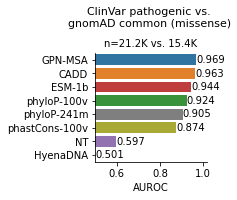

In [25]:
barplot(
    results_clinvar[~results_clinvar.Model.isin(ablation_models)],
    "AUROC",
    "ClinVar pathogenic vs.\ngnomAD common (missense)",
    y=1.2,
    #save_path="clinvar_auroc.svg",
)

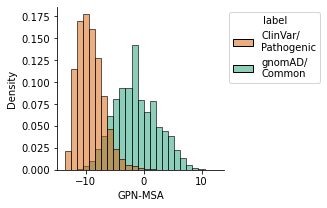

In [18]:
histplot_label(
    V_clinvar.select(["label", "GPN-MSA"]).to_pandas(),
    "ClinVar/\nPathogenic", "gnomAD/\nCommon",
    #save_path="hist_clinvar.svg",
)

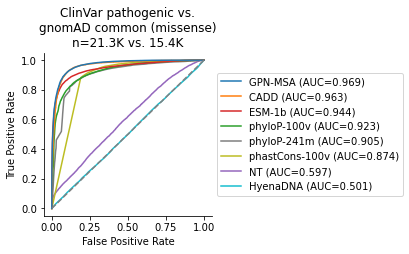

In [37]:
plot_curve(
    V_clinvar.to_pandas(),
    results_clinvar[~results_clinvar.Model.isin(ablation_models)],
    "ROC",
    "ClinVar pathogenic vs.\ngnomAD common (missense)",
    #save_path="clinvar_roc.svg",
)

### Stratifying by conservation

In [32]:
conservation_model = "phyloP-241m"
log_pval_thresh = -np.log10(0.05)  # 1.3
V_clinvar = V_clinvar.with_columns(
    pl.when(pl.col(conservation_model) < -log_pval_thresh).then(pl.lit("conserved"))
    .when(pl.col(conservation_model) > log_pval_thresh).then(pl.lit("accelerated"))
    .otherwise(pl.lit("neutral"))
    .alias("conservation")
)
V_clinvar["conservation"].value_counts()

conservation,count
str,u32
"""neutral""",7990
"""accelerated""",2037
"""conserved""",26652


In [33]:
rows = []
for c in ["all"] + list(V_clinvar["conservation"].unique()):
    V_c = V_clinvar if c == "all" else V_clinvar.filter(conservation=c)
    n_pos, n_neg = V_c["label"].sum(), (~V_c["label"]).sum()
    y_true = V_c["label"] 
    for m in [m for m in models_clinvar if m not in ablation_models]:
        y_score = -V_c[m]
        AUROC = roc_auc_score(y_true, y_score)
        AUPRC = average_precision_score(y_true, y_score)
        rows.append([c, m, AUROC, AUPRC, n_pos, n_neg])
# Conservation called "Consequence" for plotting function convenience
results_clinvar_strat = pd.DataFrame(
    rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"]
)
results_clinvar_strat.head()

,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
0,all,GPN-MSA,0.968483,0.975968,21275,15404
1,all,CADD,0.962933,0.968877,21275,15404
2,all,phyloP-100v,0.923232,0.941865,21275,15404
3,all,phyloP-241m,0.904541,0.916901,21275,15404
4,all,phastCons-100v,0.873784,0.855806,21275,15404


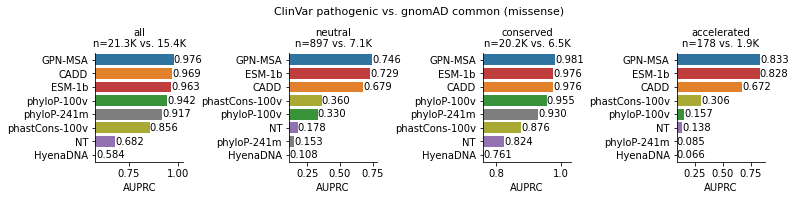

In [34]:
barplot(
    results_clinvar_strat,
    "AUPRC",
    "ClinVar pathogenic vs. gnomAD common (missense)",
    ncols=4, wspace=1.2, width=3, y=1.2,
)

## COSMIC frequent vs. gnomAD common (missense)

In [24]:
models_cosmic = dataset_models["COSMIC"]
V_cosmic = V_cosmic.drop_nulls(subset=models_cosmic)

#V_cosmic = V_cosmic.filter(
#    ~pl.col("label") | (pl.col("AF") < 0.1 / 100)
#)

n_pos, n_neg = V_cosmic["label"].sum(), (~V_cosmic["label"]).sum()
rows = []
for m in tqdm(models_cosmic):
    y_true = V_cosmic["label"]
    y_score = -V_cosmic[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append(["all", m, AUROC, AUPRC, n_pos, n_neg])
results_cosmic = pd.DataFrame(
    rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"]
).sort_values("AUPRC", ascending=False)
results_cosmic.head()

100%|██████████| 6/6 [00:00<00:00, 103.37it/s]


,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
0,all,GPN-MSA,0.776506,0.354610,183,15399
5,all,ESM-1b,0.791081,0.213785,183,15399
1,all,CADD,0.761977,0.166532,183,15399
2,all,phyloP-100v,0.693006,0.140929,183,15399
3,all,phyloP-241m,0.683706,0.089280,183,15399


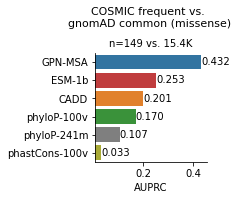

In [38]:
barplot(
    results_cosmic[~results_cosmic.Model.isin(ablation_models)],
    "AUPRC",
    "COSMIC frequent vs. \ngnomAD common (missense)",
    y=1.2,
    #save_path="cosmic_auprc.svg",
)

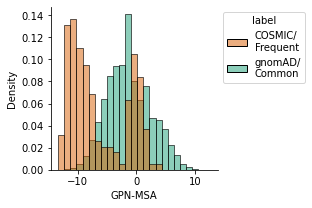

In [25]:
histplot_label(
    V_cosmic.select(["label", "GPN-MSA"]).to_pandas(),
    "COSMIC/\nFrequent", "gnomAD/\nCommon",
    #save_path="hist_cosmic.svg",
)

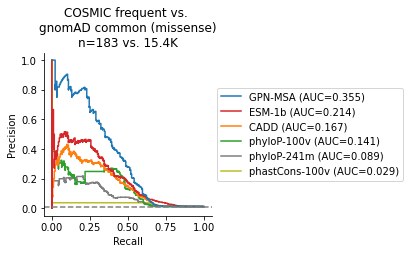

In [38]:
plot_curve(
    V_cosmic.to_pandas(),
    results_cosmic[~results_cosmic.Model.isin(ablation_models)],
    "PR",
    "COSMIC frequent vs. \ngnomAD common (missense)",
    #save_path="cosmic_pr_curve.svg",
)

## OMIM pathogenic vs. gnomAD common (regulatory)

In [26]:
consequence_models = dataset_models["OMIM"]
rows = []
for c in tqdm(consequence_models):
    V_c = V_omim if c == "all" else V_omim.filter(consequence=c)
    V_c = V_c.drop_nulls(subset=consequence_models[c])
    n_pos, n_neg = V_c["label"].sum(), (~V_c["label"]).sum()
    y_true = V_c["label"] 
    for m in consequence_models[c]:
        y_score = -V_c[m]
        AUROC = roc_auc_score(y_true, y_score)
        AUPRC = average_precision_score(y_true, y_score)
        rows.append([c, m, AUROC, AUPRC, n_pos, n_neg])
results_omim = pd.DataFrame(rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"])
results_omim.head()

100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
0,all,GPN-MSA,0.930498,0.127152,406,2573918
1,all,CADD,0.939016,0.048271,406,2573918
2,all,phyloP-100v,0.871816,0.037942,406,2573918
3,all,phyloP-241m,0.884964,0.028139,406,2573918
4,all,phastCons-100v,0.830174,0.005947,406,2573918


In [27]:
results_omim.Consequence = results_omim.Consequence.replace({
    "Promoter": "promoter",
    "Enhancer": "enhancer",
})

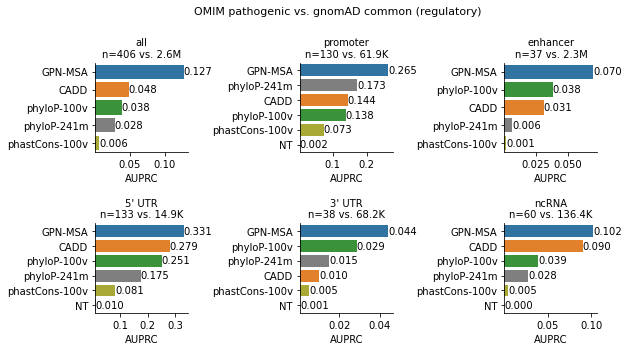

In [58]:
barplot(
    results_omim[~results_omim.Model.isin(ablation_models)],
    "AUPRC",
    "OMIM pathogenic vs. gnomAD common (regulatory)",
    nrows=2, ncols=3, hspace=0.8, wspace=1.2, width=3, height=2.3, y=1.05,
)

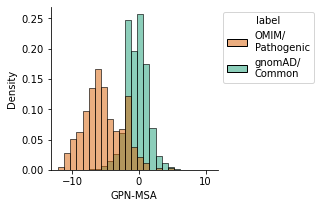

In [28]:
histplot_label(
    V_omim.select(["label", "GPN-MSA"]).to_pandas(),
    "OMIM/\nPathogenic", "gnomAD/\nCommon",
    #save_path="hist_omim.svg",
)

In [67]:
def omim_curve_plot(
    save_path=None,
    title="OMIM pathogenic vs. gnomAD common (regulatory)",
    x=None,
    y=1.03,
):
    consequence_models = dataset_models["OMIM"]
    plot_f = PrecisionRecallDisplay
    metric = "AUPRC"
    xlabel = 'Recall'
    ylabel = 'Precision'
    pos_label = "Pathogenic"

    fig, axes = plt.subplots(
        nrows=2, ncols=3, sharex=True, sharey=True, figsize=(11, 5.5),
    )
    
    rows = []
    i = 0
    for c in consequence_models:
        ax = axes.flat[i]
        V_c = V_omim.to_pandas() if c=="all" else V_omim.filter(consequence=c).to_pandas()
        V_c.dropna(subset=consequence_models[c], inplace=True)

        n_pos, n_neg = V_c.label.sum(), (~V_c.label).sum()
        pos_prop = n_pos/(n_pos+n_neg)
        sample_size = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
        subtitle = f"{c}\n{sample_size}"

        for m in np.array(consequence_models[c])[::-1]:
            if m in ablation_models: continue
            if m in ["NT", "phastCons-100v"]: continue
            AUC = average_precision_score(V_c.label, -V_c[m])
            plot_f.from_predictions(V_c.label, -V_c[m], name=m, ax=ax, label=f"{m}\n(AUC={AUC:.3f})", color=palette[m])

        ax.axhline(y=pos_prop, linestyle="--", color="gray")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        sns.despine()

        ax.legend();
        # get handles and labels
        handles, labels = ax.get_legend_handles_labels()
        # reverse the order
        handles, labels = handles[::-1], labels[::-1]
        # create the legend with the reversed order
        ax.legend(handles, labels, fontsize=8)# loc='center left', bbox_to_anchor=(1, 0.5))    

        ax.set_title(subtitle)
        i += 1
    
    fig.suptitle(title, y=y, fontsize=12, x=x)
    plt.subplots_adjust(hspace=0.5) 

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

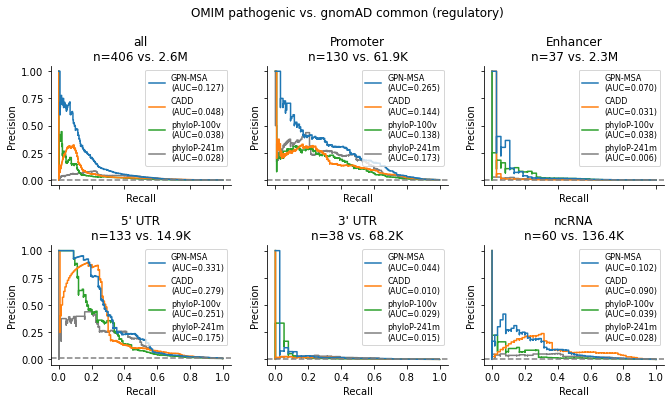

In [68]:
omim_curve_plot(
    #save_path="omim_pr_curves.svg",
)

In [63]:
examples = [
    (156_791_571, "Enhancer"),
    (113_105_781, "Promoter"),
    (22_130_605, "5' UTR"),
]

for pos, consequence in examples:
    print(pos, consequence)
    models = dataset_models["OMIM"][consequence]
    df = (
        V_omim
        .filter(consequence=consequence)
        .drop_nulls(subset=models)
    )
    df = (
        df
        .with_columns(
            pl.col(models).rank() / len(df) * 100
        )
    )
    df = df.filter(pos=pos).select(models).transpose(include_header=True).sort("column_0")
    df = df.with_columns(
        pl.col("column") + " -- " + pl.col("column_0").round_sig_figs(1).cast(str) + "\%"
    )
    print(', '.join(df["column"]))

156791571 Enhancer
GPN-MSA -- 0.004\%, phastCons-100v -- 0.6\%, CADD -- 2.0\%, phyloP-100v -- 5.0\%, phyloP-241m -- 50.0\%
113105781 Promoter
GPN-MSA -- 0.01\%, phyloP-100v -- 0.3\%, phastCons-100v -- 0.5\%, CADD -- 0.8\%, phyloP-241m -- 0.9\%, NT -- 30.0\%
22130605 5' UTR
CADD -- 0.2\%, GPN-MSA -- 0.3\%, phyloP-241m -- 1.0\%, phastCons-100v -- 2.0\%, phyloP-100v -- 6.0\%, NT -- 90.0\%


## gnomAD rare vs. common

In [29]:
consequence_models = dataset_models["gnomAD"]
results_gnomad = []
for c in tqdm(list(consequence_models.keys())):
    df_c = V_gnomad if c == "all" else V_gnomad.filter(consequence=c)
    df_c = df_c.drop_nulls(subset=consequence_models[c])
    n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
    for m in consequence_models[c]:
        odds_ratio = (
            get_odds_ratio(df_c.select(["label", pl.col(m).alias("score")]), [30, 60, 90])
            .with_columns(
                Consequence=pl.lit(c), Model=pl.lit(m),
                n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg),
            )
        )
        results_gnomad.append(odds_ratio)
results_gnomad = pl.concat(results_gnomad).to_pandas()
results_gnomad.head()

  0%|          | 0/12 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [49]:
replacements = {
    "5_prime_UTR": "5' UTR",
    "3_prime_UTR": "3' UTR",
    "upstream_gene": "upstream-of-gene",
    "downstream_gene": "downstream-of-gene",
    "non_coding_transcript_exon": "ncRNA",
}
results_gnomad['Consequence'] = results_gnomad['Consequence'].replace(replacements)

In [50]:
(results_gnomad[(results_gnomad.n==30) & ~results_gnomad.Model.isin(ablation_models)].p_value < 0.05).value_counts()

p_value
True    53
Name: count, dtype: int64

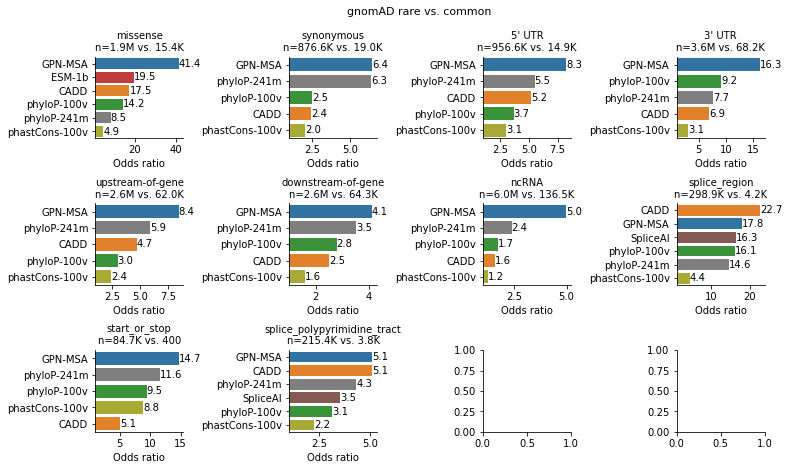

In [51]:
barplot(
    results_gnomad[
        (results_gnomad.n==30) &
        (results_gnomad.p_value < 0.05) &
        ~results_gnomad.Model.isin(ablation_models)
    ],
    "Odds ratio",
    "gnomAD rare vs. common",
    nrows=3, ncols=4, hspace=0.8, wspace=1.2, width=3, height=2.3, y=0.98,
)

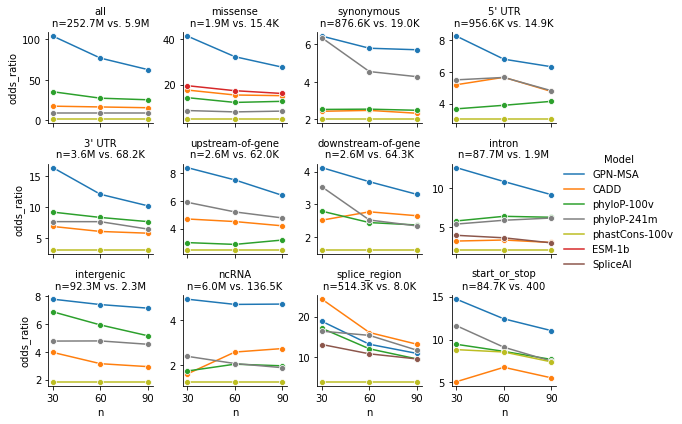

In [26]:
g = sns.relplot(
    data=results_gnomad[results_gnomad.p_value<=0.05],
    x="n",
    y="Odds ratio",
    hue="Model",
    col="subtitle",
    kind="line",
    marker="o",
    height=2,
    col_wrap=4,
    facet_kws={'sharey': False, 'sharex': True},
    palette=palette,
    #markersize=5,
)
g.set(xticks=[30, 60, 90])
g.set_titles(col_template="{col_name}", row_template="{row_name}");

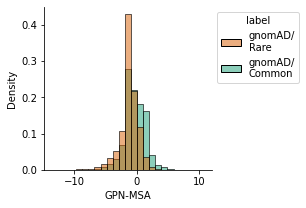

In [34]:
# TODO: maybe dropna of the respective category?
histplot_label(
    V_gnomad.select(["label", "GPN-MSA"]).sample(n=10_000_000, seed=42).to_pandas(),
    "gnomAD/\nRare", "gnomAD/\nCommon",
    #save_path="hist_gnomad.svg",
)

(0.0, 0.007)

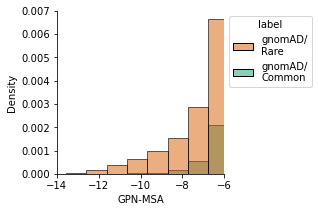

In [35]:
histplot_label(
    V_gnomad.select(["label", "GPN-MSA"]).sample(n=10_000_000, seed=42).to_pandas(),
    "gnomAD/\nRare", "gnomAD/\nCommon",
)
plt.xlim(-14, -6)
plt.ylim(0, 7e-3)
#plt.savefig(plot_dir + "hist_gnomad_zoom.svg", bbox_inches="tight")

### Stratifying by conservation

In [9]:
V_gnomad.sort("phyloP-100v", descending=True, nulls_last=True).head()

chrom,pos,ref,alt,consequence,label,GPN-MSA,CADD,phyloP-100v,phyloP-241m,phastCons-100v,ESM-1b,SpliceAI
str,i64,str,str,str,bool,f32,f32,f64,f64,f64,f64,f32
"""5""",140841990,"""A""","""C""","""synonymous""",true,-0.174805,0.182891,20.0,3.79,-0.0,null,-0.0
"""5""",141214372,"""G""","""A""","""synonymous""",true,0.935547,-0.009105,20.0,-0.171,-0.0,null,-0.0
"""5""",141214597,"""C""","""A""","""synonymous""",true,0.4609375,0.114301,20.0,0.435,-0.0,null,-0.0
"""5""",141214723,"""G""","""A""","""synonymous""",true,-0.567871,-0.248191,20.0,4.337,-0.0,null,-0.0
"""5""",141214918,"""C""","""A""","""synonymous""",true,-1.937012,-0.013513,20.0,-0.972,-0.0,null,-0.0


In [13]:
conservation_model = "phyloP-241m"
log_pval_thresh = -np.log10(0.05)  # 1.3
models_gnomad_strat = [m for m in dataset_models["gnomAD"]["all"] if m not in ablation_models]
V_gnomad_strat = (
    V_gnomad.drop_nulls(subset=models_gnomad_strat)
    .with_columns(
        pl.when(pl.col(conservation_model) < -log_pval_thresh).then(pl.lit("conserved"))
        .when(pl.col(conservation_model) > log_pval_thresh).then(pl.lit("accelerated"))
        .otherwise(pl.lit("neutral"))
        .alias("conservation")
    )
)
V_gnomad_strat["conservation"].value_counts()

conservation,count
str,u32
"""conserved""",18036217
"""neutral""",219053484
"""accelerated""",21511215


In [16]:
results_gnomad_strat = []
for c in tqdm(["all"] + list(V_gnomad_strat["conservation"].unique())):  
    df_c = V_gnomad_strat if c == "all" else V_gnomad_strat.filter(conservation=c)
    n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
    for m in models_gnomad_strat:
        odds_ratio = (
            get_odds_ratio(df_c.select(["label", pl.col(m).alias("score")]), [30, 60, 90])
            .with_columns(
                Consequence=pl.lit(c), Model=pl.lit(m),
                n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg),
            )
        )
        results_gnomad_strat.append(odds_ratio)
results_gnomad_strat = pl.concat(results_gnomad_strat).to_pandas()
results_gnomad_strat.head()

100%|██████████| 4/4 [03:15<00:00, 48.98s/it]


,n,Odds ratio,p_value,Consequence,Model,n_pos,n_neg
0,30,103.725214,0.000000e+00,all,GPN-MSA,252706195,5894721
1,60,76.681433,0.000000e+00,all,GPN-MSA,252706195,5894721
2,90,62.576950,0.000000e+00,all,GPN-MSA,252706195,5894721
3,30,17.571563,6.150975e-184,all,CADD,252706195,5894721
4,60,16.612214,0.000000e+00,all,CADD,252706195,5894721


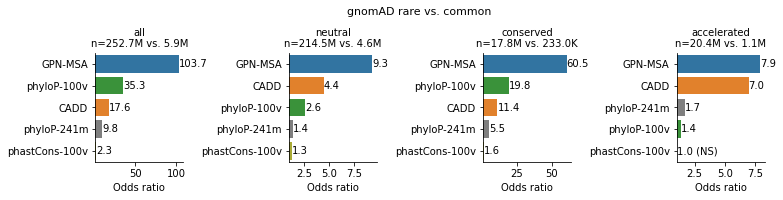

In [ ]:
# pay attention to absolute scale of odds ratio
# also putative accelerated, could be due to badly aligned column
# notice phastCons non-significant on accelerated
barplot(
    results_gnomad_strat[
        (results_gnomad_strat.n==30)
    ],
    "Odds ratio",
    "gnomAD rare vs. common",
    ncols=4, wspace=1.2, width=3, y=1.2,
)

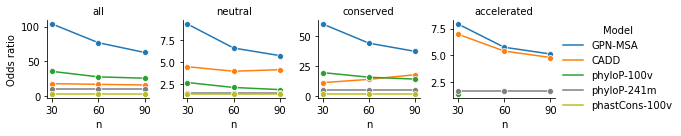

In [ ]:
g = sns.relplot(
    data=results_gnomad_strat[results_gnomad_strat.p_value<=0.05],
    x="n",
    y="Odds ratio",
    hue="Model",
    col="Consequence",
    kind="line",
    marker="o",
    height=2,
    col_wrap=4,
    facet_kws={'sharey': False, 'sharex': True},
    palette=palette,
    #markersize=5,
)
g.set(xticks=[30, 60, 90])
g.set_titles(col_template="{col_name}", row_template="{row_name}");

## gnomAD Enformer set (low-frequency vs. common)

In [16]:
enformer_models = dataset_models["gnomAD_Enformer"]
results_enformer = []
df_c = V_enformer.drop_nulls(subset=enformer_models)
n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
for m in tqdm(enformer_models):
    odds_ratio = (
        get_odds_ratio(df_c.select(["label", pl.col(m).alias("score")]), [30, 60, 90])
        .with_columns(Model=pl.lit(m), n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg))
    )
    results_enformer.append(odds_ratio)
results_enformer = pl.concat(results_enformer).to_pandas()
results_enformer.head()

100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


,n,Odds ratio,p_value,Model,n_pos,n_neg
0,30,3.387194,1.141404e-11,GPN-MSA,7627870,6208835
1,60,3.202563,3.226402e-19,GPN-MSA,7627870,6208835
2,90,2.848963,6.328104e-22,GPN-MSA,7627870,6208835
3,30,1.181566,2.751448e-01,CADD,7627870,6208835
4,60,0.947404,6.551777e-01,CADD,7627870,6208835


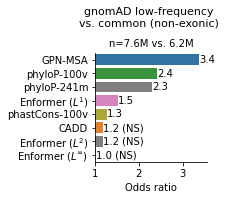

In [17]:
barplot(
    results_enformer[
        (results_enformer.n==30)
    ].replace({
        "Enformer_l1": r"Enformer ($L^1$)",
        "Enformer_l2": r"Enformer ($L^2$)",
        "Enformer_linf": r"Enformer ($L^\infty$)",
    }),
    "Odds ratio",
    "gnomAD low-frequency\nvs. common (non-exonic)",
    y=1.2,
)

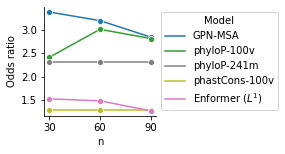

In [18]:
plt.figure(figsize=(2,2))
g = sns.lineplot(
    data=results_enformer[results_enformer.p_value < 0.05].replace({
        "Enformer_l1": r"Enformer ($L^1$)",
        "Enformer_l2": r"Enformer ($L^2$)",
        "Enformer_linf": r"Enformer ($L^\infty$)",
    }),
    x="n",
    y="Odds ratio",
    hue="Model",
    marker="o",
    palette=palette,
)
g.set(xticks=[30, 60, 90])
sns.despine()
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));

## gnomAD ablation set (rare vs. common subsample)

In [8]:
gnomad_ablation_models = dataset_models["gnomAD_ablation"]
results_gnomad_ablation = []
df_c = V_gnomad_ablation.drop_nulls(subset=gnomad_ablation_models)
n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
for m in tqdm(gnomad_ablation_models):
    odds_ratio = (
        get_odds_ratio(df_c.select(["label", pl.col(m).alias("score")]), [30, 60, 90])
        .with_columns(Model=pl.lit(m), n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg))
    )
    results_gnomad_ablation.append(odds_ratio)
results_gnomad_ablation = pl.concat(results_gnomad_ablation).to_pandas()
results_gnomad_ablation.head()

100%|██████████| 47/47 [01:01<00:00,  1.32s/it]


,n,Odds ratio,p_value,Model,n_pos,n_neg
0,30,41.764015,0.0,GPN-MSA,5913139,5905873
1,60,31.397468,0.0,GPN-MSA,5913139,5905873
2,90,25.725412,0.0,GPN-MSA,5913139,5905873
3,30,43.117784,0.0,multiz100way/89/128/64/True/defined.phastCons....,5913139,5905873
4,60,32.691802,0.0,multiz100way/89/128/64/True/defined.phastCons....,5913139,5905873


## Ablation study

In [9]:
results_ablation = [
    df[df.Model.isin(["GPN-MSA"] + ablation_models)]
    for df in [
        #results_clinvar[["Model", "AUROC"]].rename(columns={"AUROC": "ClinVar"}),
        #results_cosmic[["Model", "AUPRC"]].rename(columns={"AUPRC": "COSMIC"}),
        #results_omim[results_omim.Consequence=="all"][["Model", "AUPRC"]].rename(columns={"AUPRC": "OMIM"}),
        results_gnomad_ablation.query('n==30')[["Model", "Odds ratio"]].rename(columns={"Odds ratio": "gnomAD"}),
    ]
]

results_ablation = reduce(lambda x, y: x.merge(y, on="Model", how="left"), results_ablation).replace("GPN-MSA", original_name)
results_ablation.head()

,Model,gnomAD
0,multiz100way/89/128/64/True/defined.phastCons....,41.764015
3,multiz100way/89/128/64/True/defined.phastCons....,43.117784
6,multiz100way/89/128/64/True/defined.phastCons....,39.249922
9,multiz100way/89/128/64/True/defined.phastCons....,35.285526
12,multiz100way/89/128/64/True/defined.phastCons....,30.837863


In [10]:
results_ablation[[col for col in results_ablation.columns if col not in ["Model", "Ablation"]]].corr(method="spearman")

,gnomAD
gnomAD,1.0


In [11]:
hparam_name = {
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Default",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/False/True/True": "w/o MSA",
    "msa_multiz100way/89": "MSA frequency (no neural net)",
    "conservation_combination": "Combined phyloP and phastCons",

    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/[\d]+/30000/True/True/True": "Train on 50% most conserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_1.00_0.00/medium/0.1/[\d]+/30000/True/True/True": "Train on 100% of genome",
    
    r"multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Include closest primates",
    r"multiz100way_mammals/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 mammals",
    r"multiz100way_vertebrates/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 vertebrates",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/False/True": "Don't upweight conserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/False": "Don't replace non-conserved",
    
    r"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Window size = 256",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.64": "Window size = 64",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.32": "Window size = 32",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.16": "Window size = 16",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.8": "Window size = 8",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.4": "Window size = 4",
}

results_ablation["Ablation"] = None
for k, v in hparam_name.items():
    results_ablation.loc[results_ablation.Model.str.match(k), "Ablation"] = v
results_ablation = results_ablation.dropna(subset="Ablation")
results_ablation.Ablation.value_counts()

Ablation
Default                          3
Train on 50% most conserved      3
Window size = 64                 3
Window size = 32                 3
Window size = 16                 3
Window size = 8                  3
Window size = 4                  3
Don't replace non-conserved      3
Don't upweight conserved         3
w/o MSA                          3
Window size = 256                3
51 vertebrates                   3
51 mammals                       3
Include closest primates         3
Train on 100% of genome          3
MSA frequency (no neural net)    1
Combined phyloP and phastCons    1
Name: count, dtype: int64

In [12]:
results_ablation = (
    results_ablation.groupby("Ablation")[
        [col for col in results_ablation.columns if col not in ["Model", "Ablation"]]
    ].agg([
        "max",
        "median",
        "mean",
        "std",
    ])
)
results_ablation.index.name = None
results_ablation = results_ablation.loc[hparam_name.values()]
results_ablation = results_ablation.round(3)
results_ablation

gnomAD                       
                                  max  median    mean    std
Default                        43.118  41.764  41.377  1.963
w/o MSA                         3.093   2.747   2.773  0.307
MSA frequency (no neural net)  15.122  15.122  15.122    NaN
Combined phyloP and phastCons  13.919  13.919  13.919    NaN
Train on 50% most conserved    35.286  30.838  32.116  2.762
Train on 100% of genome        30.717  27.720  27.964  2.639
Include closest primates       26.721  24.102  24.674  1.829
51 mammals                     43.408  41.583  41.381  2.134
51 vertebrates                 46.792  39.121  41.624  4.476
Don't upweight conserved       39.991  38.605  37.094  3.881
Don't replace non-conserved    45.213  40.709  41.853  2.959
Window size = 256              42.957  38.022  37.908  5.106
Window size = 64               39.522  38.173  37.478  2.467
Window size = 32               38.866  36.768  36.664  2.256
Window size = 16               31.623  28.532  29.203  2.164
Window size = 8                21.943  21.492  21.159  0.993
Window size = 4                14.789  13.178  13.457  1.217

In [153]:
categories = ["ClinVar", "COSMIC", "OMIM", "gnomAD"]
results_ablation_tex = pd.DataFrame()

def mean_std_str(mean, std):
    if pd.isna(mean):
        return "NA"
    elif pd.isna(std):
        return f"{mean:.3f}"
    else:
        return f"{mean:.3f} ± {std:.3f}"
    
def mean_str(mean, is_gnomad):
    if pd.isna(mean):
        return "NA"
    else:
        if is_gnomad:
            return f"{mean:.1f}"
        else:
            return f"{mean:.3f}"

for category in categories:
    mean_col = (category, "mean")
    std_col = (category, "std")
    
    results_ablation_tex[category] = results_ablation.apply(
        #lambda row: mean_std_str(row[mean_col], row[std_col]), axis=1
        lambda row: mean_str(row[mean_col], category=="gnomAD"), axis=1
    )
results_ablation_tex

,ClinVar,COSMIC,OMIM,gnomAD,GWAS
Default,0.966,0.342,0.115,37.0,0.735
w/o MSA,0.582,0.014,0.000,1.9,0.654
MSA frequency (no neural net),0.947,0.266,0.030,17.3,NA
Train on 50% most conserved,0.960,0.237,0.122,28.7,0.732
Train on 100% of genome,0.957,0.207,0.119,26.5,0.730
Include closest primates,0.950,0.211,0.128,31.5,0.728
51 mammals,0.962,0.317,0.067,33.3,0.734
51 vertebrates,0.964,0.334,0.090,33.8,0.731
Don't upweight conserved,0.964,0.297,0.122,34.2,0.732
Don't replace non-conserved,0.964,0.328,0.102,33.1,0.733


In [154]:
print(results_ablation_tex.to_latex(escape="latex"))

\begin{tabular}{llllll}
\toprule
 & ClinVar & COSMIC & OMIM & gnomAD & GWAS \\
\midrule
Default & 0.966 & 0.342 & 0.115 & 37.0 & 0.735 \\
w/o MSA & 0.582 & 0.014 & 0.000 & 1.9 & 0.654 \\
MSA frequency (no neural net) & 0.947 & 0.266 & 0.030 & 17.3 & NA \\
Train on 50\% most conserved & 0.960 & 0.237 & 0.122 & 28.7 & 0.732 \\
Train on 100\% of genome & 0.957 & 0.207 & 0.119 & 26.5 & 0.730 \\
Include closest primates & 0.950 & 0.211 & 0.128 & 31.5 & 0.728 \\
51 mammals & 0.962 & 0.317 & 0.067 & 33.3 & 0.734 \\
51 vertebrates & 0.964 & 0.334 & 0.090 & 33.8 & 0.731 \\
Don't upweight conserved & 0.964 & 0.297 & 0.122 & 34.2 & 0.732 \\
Don't replace non-conserved & 0.964 & 0.328 & 0.102 & 33.1 & 0.733 \\
Window size = 256 & 0.966 & 0.359 & 0.117 & 37.3 & 0.736 \\
Window size = 64 & 0.965 & 0.334 & 0.107 & 35.8 & 0.730 \\
Window size = 32 & 0.964 & 0.317 & 0.107 & 34.9 & 0.726 \\
Window size = 16 & 0.962 & 0.242 & 0.094 & 28.6 & 0.717 \\
Window size = 8 & 0.958 & 0.188 & 0.078 & 23.3 & 0.712 

## ClinVar pathogenic vs. benign (missense)

In [70]:
models_clinvar_benign = dataset_models["ClinVar_benign"]
V_clinvar_benign = V_clinvar_benign.drop_nulls(subset=models_clinvar_benign)
n_pos, n_neg = V_clinvar_benign["label"].sum(), (~V_clinvar_benign["label"]).sum()
rows = []
for m in tqdm(models_clinvar_benign):
    y_true = V_clinvar_benign["label"]
    y_score = -V_clinvar_benign[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append(["all", m, AUROC, AUPRC, n_pos, n_neg])
results_clinvar_benign = pd.DataFrame(
    rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"]
).sort_values("AUROC", ascending=False)
results_clinvar_benign.head()

100%|██████████| 6/6 [00:00<00:00, 36.07it/s]


,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
5,all,ESM-1b,0.914224,0.904751,21275,26993
1,all,CADD,0.913639,0.877106,21275,26993
0,all,GPN-MSA,0.906944,0.876353,21275,26993
2,all,phyloP-100v,0.855577,0.808643,21275,26993
3,all,phyloP-241m,0.803965,0.704849,21275,26993


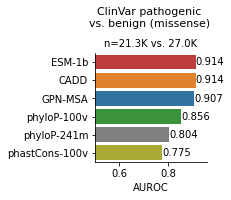

In [71]:
barplot(
    results_clinvar_benign,
    "AUROC",
    "ClinVar pathogenic\nvs. benign (missense)",
    y=1.2,
    #save_path="clinvar_benign_auroc.svg",
)

## DMS (missense)

In [100]:
models_dms = dataset_models["DMS"]
V_dms = V_dms.drop_nulls(subset=models_dms)
rows = []
for DMS in V_dms["DMS"].unique(maintain_order=True):
    V_c = V_dms.filter(DMS=DMS)
    for m in models_dms:
        rows.append([DMS, m, spearmanr(V_c["label"], V_c[m])[0]])
results_dms = pd.DataFrame(
    rows, columns=["Consequence", "Model", "Spearman"]
)
results_dms.head(6)

,Consequence,Model,Spearman
0,DMS_TADBP_HUMAN_Bolognesi_2019,GPN-MSA,-0.071710
1,DMS_TADBP_HUMAN_Bolognesi_2019,CADD,0.046299
2,DMS_TADBP_HUMAN_Bolognesi_2019,phyloP-100v,-0.068083
3,DMS_TADBP_HUMAN_Bolognesi_2019,phyloP-241m,0.077465
4,DMS_TADBP_HUMAN_Bolognesi_2019,phastCons-100v,0.016584
5,DMS_TADBP_HUMAN_Bolognesi_2019,ESM-1b,-0.069276


In [101]:
results_dms.groupby("Model")["Spearman"].mean().sort_values(ascending=False)

Model
ESM-1b            0.423723
CADD              0.337638
GPN-MSA           0.322003
phyloP-100v       0.230236
phastCons-100v    0.156252
phyloP-241m       0.141147
Name: Spearman, dtype: float64

In [102]:
results_dms.groupby("Model")["Spearman"].median().sort_values(ascending=False)

Model
ESM-1b            0.454056
GPN-MSA           0.354891
CADD              0.320596
phyloP-100v       0.273353
phyloP-241m       0.151679
phastCons-100v    0.141818
Name: Spearman, dtype: float64

In [107]:
V_dms["DMS"].unique().shape

(31,)

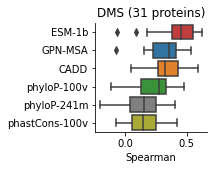

In [111]:
plt.figure(figsize=(2,2))
g = sns.boxplot(
    data=results_dms, y="Model", x="Spearman", palette=palette,
    order=results_dms.groupby("Model")["Spearman"].median().sort_values(ascending=False).index.values
);
plt.ylabel("")
plt.title("DMS (31 proteins)")
sns.despine()
#plt.savefig(plot_dir + "dms.pdf", bbox_inches="tight")